In [38]:
import pandas as pd
import warnings
import numpy as np
import tensorflow as tf
import os
import sys
child_dir = os.path.abspath('dfl')
sys.path.append(child_dir)
from dfl.whittle import newWhittleIndex
from dfl.trajectory import getSimulatedTrajectories
from dfl.policy import getProbs
from dfl.ope import eval_policy
import matplotlib.pyplot as plt
import datetime
import random
from sklearn.cluster import KMeans

In [39]:
# Helper functions to generate transition dynamics
def get_simpleish_transitions(n_history,n_benefs):
    transitions_full = np.zeros((n, 2 ** n_history, 2, 2 ** n_history))
    transitions = np.zeros((2,2))
    for i in range(n):
        transitions[0, 0] = np.random.uniform(0, 0.5)
        transitions[0, 1] = np.random.uniform(.5, .999)
        transitions[1, 0] = np.random.uniform(0, .7)
        transitions[1, 1] = np.random.uniform(.701, .999)
        for j in range(2 ** history):
            bin_val = bin(j)[2:]
            curr_state = (n_history-len(bin_val))*'0' + bin_val
            next_state_0 = int(curr_state[1:] + '0', 2)
            next_state_1 = int(curr_state[1:] + '1', 2)

            # action = 0
            transitions_full[i, j, 0, next_state_0] = 1 - transitions[int(curr_state[-1]),0]
            transitions_full[i, j, 0, next_state_1] = transitions[int(curr_state[-1]),0]
            # action = 1
            transitions_full[i, j, 1, next_state_0] = 1 - transitions[int(curr_state[-1]),1]
            transitions_full[i, j, 1, next_state_1] = transitions[int(curr_state[-1]),1]
    return transitions_full

In [40]:
# Initialize parameters
L=11
history=3
n_states = 2 ** history
n=500
K=60
gamma=0.99

# We can't release the real world data, but creating synthetic transitions here. Change this as needed.
transition_probabilities = get_simpleish_transitions(history,n)

# generate naive rewards for later
reward_numpy = np.zeros((n, n_states))
for i in range(int(n_states/2)):
    reward_numpy[2*i + 1] = 1
reward_opt = tf.constant(reward_numpy,dtype=tf.float32)

In [41]:
# naive whittle indices for later

w_opt = newWhittleIndex(tf.constant(transition_probabilities, dtype=tf.float32),reward_opt).numpy()
w_opt = np.reshape(w_opt,(n,n_states))
print(transition_probabilities.shape)

(500, 8, 2, 8)


In [42]:
# We can't release the real world data, but creating synthetic data here. 
# The getSimulatedTrajectories takes in the n: number of beneficiaries, T: length of program, K: resource budget,
# n_trials: number of trajectories to generate, T_data: transitions data, R_data: the rewards with which you want to 
# generate the synthetic trajectories, w: the whittle indices from the rewards and transitions

# You can leave the rest of the parameters as is, or look at the getSimulatedTrajectories code to edit the policy 
# with which you generate policies: 0=random, 1=rount robin, 2=whittle top-k, 3=whittle soft-k

# Lastly, if you want to create a fake trajectory outside of any pre-existing policy, just create a state and action
# trajectory of size (len(policies), n_trials, n_benefs, T) where you set the appropriate state and action values you want to use

# Create the state/action trajectories
_, _, state_traj, action_traj, _ = getSimulatedTrajectories(
                                                                n_benefs=n, T=L+1, K=K, n_trials=1, gamma=gamma,
                                                                T_data=transition_probabilities, R_data=reward_opt.numpy(),
                                                                w=w_opt, replace=False, policies=[3], fast=True
                                                            )

In [43]:
# Source and target functions for the command "Move all service calls from states {111,101,110,011,001} to {000,100,010}"

def source_state(h):
    called_good_state = set()
    for arm in range(n):
        if edited_action_traj[0,0,h,arm]==1 and edited_state_traj[0,0,h,arm] in {1,3,5,6,7}:
            called_good_state.add(arm)
        
    return called_good_state

def target_state(h):
    uncalled_bad_state = set()
    for arm in range(n):
        if edited_action_traj[0,0,h,arm]==0 and edited_state_traj[0,0,h,arm] in {0,2,4}:
            uncalled_bad_state.add(arm)
    return uncalled_bad_state

In [44]:
# Applying aggregate command to trajectories

edited_action_traj = np.copy(action_traj)
edited_state_traj = np.copy(state_traj)

def aggregate_command(source, target):
    '''
    state_trajectory - 

    source - function that takes the current timestep and returns a valid list of beneficiaries to remove actions from 

    target - function that takes the current timestep and returns a valid list of beneficiaries to give actions to 
    
    f - feature dataframe

    t - transition matrix
    '''
    
    for h in range(L):
        uncalled_target = target(h)
        called_source = source(h)
        print('source: ' + str(len(called_source)))
        print('target: '+ str(len(uncalled_target)))
        total = len(uncalled_target)
        interventions_available = len(called_source)
        probability_switching = min(float(interventions_available)/total,1)
        num_moved = 0
        arms = np.arange(n)
        np.random.shuffle(arms)
        for arm in arms:
            if edited_action_traj[0,0,h,arm] == 0 and arm in uncalled_target and called_source != set():
                if np.random.uniform()<probability_switching:
                    num_moved+=1
                    edited_action_traj[0,0,h,arm] = 1
                    temp_index = called_source.pop()
                    edited_action_traj[0,0,h,temp_index] = 0

In [45]:
edited_action_traj = np.copy(action_traj)
edited_state_traj = np.copy(state_traj)
aggregate_command(source_state,target_state)

source: 38
target: 155
source: 32
target: 216
source: 29
target: 237
source: 22
target: 250
source: 25
target: 246
source: 21
target: 272
source: 24
target: 275
source: 24
target: 256
source: 28
target: 259
source: 22
target: 254
source: 28
target: 252


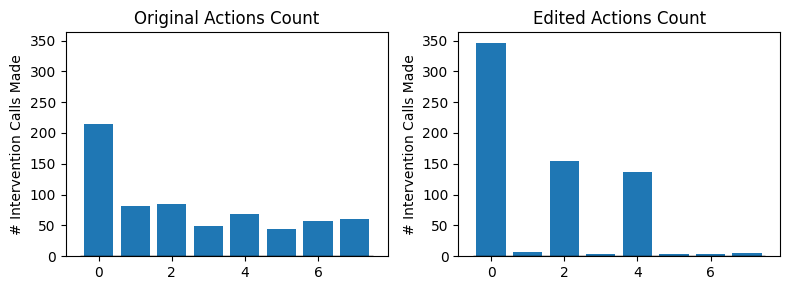

In [46]:
# Visualize how the actions changed after aggregate edits

def get_action_breakdown(states,actions,timestep=None):
    actions_by_state = np.zeros(n_states)
    for i in range(n): # for each beneficary
        for j in range(L): # for each timestep
            if timestep == None:
                actions_by_state[int(states[0,0,j,i])] += actions[0,0,j,i]
            else:
                if j ==timestep:
                    actions_by_state[int(states[0,0,j,i])] += actions[0,0,j,i]
    return actions_by_state

fig, axs = plt.subplots(1, 2, figsize=(8, 3),sharey=True)
axs[0].set_title('Original Actions Count')
axs[0].set_ylabel('# Intervention Calls Made')
axs[0].bar(np.arange(n_states), get_action_breakdown(state_traj, action_traj))

axs[1].bar(np.arange(n_states), get_action_breakdown(edited_state_traj,edited_action_traj))
axs[1].set_title('Edited Actions Count')
axs[1].set_ylabel('# Intervention Calls Made')

axs[1].hlines(0, -0.5, 7.5, colors='black', linewidth=1)
axs[0].hlines(0, -0.5, 7.5, colors='black', linewidth=1)
axs[1].yaxis.set_tick_params(labelbottom=True)


plt.tight_layout()
plt.show()

In [ ]:
# WHIRL - RUN IRL WITH NEW TRAJECTORIES
epochs = 50
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
rewards = np.zeros((n, n_states))
reward_param_edited = tf.Variable(rewards,dtype=float)
for epoch in range(epochs):
    print("epoch: {e}".format(e=epoch))
    with tf.GradientTape() as tape:
        w = newWhittleIndex(tf.constant(transition_probabilities,dtype=tf.float32), reward_param_edited)
        w = tf.reshape(w, (n, n_states))
        print('WHITTLE')
        print(w[0])
        performance, _, _, _,_ = eval_policy(state_record=edited_state_traj, action_record=edited_action_traj, w=w, w_opt=w_opt, H=L, K=K,
                                                  gamma=gamma,
                                                 target_policy_name='soft-whittle', beh_policy_name='soft-whittle',
                                                 transition_probabilities=transition_probabilities, epsilon=0.1, reward_estimate=reward_param_edited, rewards_true=reward_opt)
    grad = tape.gradient(performance, reward_param_edited)
    optimizer.apply_gradients(zip([grad], [reward_param_edited]))
#     print("reward: {r}".format(r = reward_param_edited))
    print("performance: {p}".format(p = performance))
#     print("gradient: {g}".format(g = grad))
    
print("reward: {r}".format(r = reward_param_edited))
df = pd.DataFrame(reward_param_edited.numpy())
# df.to_excel('risk_rewards.xlsx')

epoch: 0
WHITTLE
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0.], shape=(8,), dtype=float32)
performance: 1834.5386962890625
epoch: 1
WHITTLE
tf.Tensor(
[-0.00394046 -0.02497406 -0.0192605  -0.02183953 -0.00394046 -0.02497405
 -0.01926035 -0.02183946], shape=(8,), dtype=float32)
performance: 1647.1724853515625
epoch: 2
WHITTLE
tf.Tensor(
[-0.00608805 -0.04967721 -0.03639369 -0.04435399 -0.00608805 -0.04967725
 -0.03639381 -0.04435369], shape=(8,), dtype=float32)
performance: 1528.0626220703125
epoch: 3
WHITTLE
tf.Tensor(
[-0.00764686 -0.07415596 -0.0525662  -0.06720874 -0.00764686 -0.07415652
 -0.0525662  -0.06720859], shape=(8,), dtype=float32)
performance: 1456.620361328125
epoch: 4
WHITTLE
tf.Tensor(
[-0.0090021  -0.09743595 -0.06798121 -0.08922029 -0.0090017  -0.09743595
 -0.06798115 -0.08922037], shape=(8,), dtype=float32)
performance: 1406.5831298828125
epoch: 5
WHITTLE
tf.Tensor(
[-0.01031864 -0.119178   -0.08269465 -0.10994661 -0.01031837 -0.1191783
 -0.08269477 -0.10994655], shape=(8,), d

performance: 1106.0872802734375
epoch: 45
WHITTLE
tf.Tensor(
[-0.09304923 -0.35745764 -0.32048237 -0.34680748 -0.09304923 -0.35745764
 -0.32047856 -0.34680796], shape=(8,), dtype=float32)
performance: 1105.133056640625
epoch: 46
WHITTLE
tf.Tensor(
[-0.09494619 -0.35828018 -0.32223427 -0.34775567 -0.09494588 -0.35828018
 -0.32223237 -0.3477552 ], shape=(8,), dtype=float32)
performance: 1102.681396484375
epoch: 47


In [ ]:
# Get whittle index with new rewards so we can generate hypothetical trajectories for next 10 timesteps

# df = pd.read_excel('risk_rewards.xlsx')
# reward_param_edited = tf.Variable(df.values[:,1:], dtype.float32)

w = newWhittleIndex(tf.constant(transition_probabilities,dtype=tf.float32), reward_param_edited)
w.shape

In [ ]:
# Generate hypothetical trajectories using the IRL rewards
gamma=0.99
num_traj = 60
edited_state_traj_multiple = np.zeros((num_traj,1,L+1,n))
edited_action_traj_multiple = np.zeros((num_traj,1,L+1,n))
w = np.reshape(w,(n,transition_probabilities.shape[1]))
for i in range(num_traj):

    _, _, state_record_edited, action_record_edited, _ = getSimulatedTrajectories(
                                                                    n_benefs=n, T=L+1, K=K, n_trials=1, gamma=gamma,
                                                                    T_data=transition_probabilities, R_data=reward_param_edited.numpy(),
                                                                    w=w, replace=False, policies=[3], fast=True
                                                                    )
    
    edited_state_traj_multiple[i,0,:,:] = state_record_edited
    edited_action_traj_multiple[i,0,:,:] = action_record_edited
    

In [ ]:
# Generate trajectories using the original rewards
reward_numpy = np.zeros((n, n_states))
for i in range(int(n_states/2)):
    reward_numpy[2*i + 1] = 1

reward_opt = tf.constant(reward_numpy,dtype=tf.float32)
w_opt = newWhittleIndex(tf.constant(transition_probabilities, dtype=tf.float32),reward_opt).numpy()
w_opt = np.reshape(w_opt,(n,transition_probabilities.shape[1]))


state_traj_multiple = np.zeros((num_traj,1,L+1,n))
action_traj_multiple = np.zeros((num_traj,1,L+1,n))


for i in range(num_traj):
    _, _, state_record_original, action_record_original, _ = getSimulatedTrajectories(
                                                                    n_benefs=n, T=L+1, K=K, n_trials=1, gamma=gamma,
                                                                    T_data=transition_probabilities, R_data=reward_opt.numpy(),
                                                                    w=w_opt, replace=False, policies=[3], fast=True
                                                                    )
    state_traj_multiple[i,0,:,:] = state_record_original
    action_traj_multiple[i,0,:,:] = action_record_original


In [ ]:
# Count original and edited interventions over states
edited_actions_summary_state = np.zeros(n_states)
edited_listening_summary_state = np.zeros(n_states)
actions_summary_state = np.zeros(n_states)
listening_summary_state = np.zeros(n_states)
for traj in range(num_traj):
    for i in range(n): # for each beneficary
        for h in range(L): # for each timestep
            edited_actions_summary_state[int(edited_state_traj_multiple[traj,0,h,i])] += edited_action_traj_multiple[traj,0,h,i]
            edited_listening_summary_state[int(edited_state_traj_multiple[traj,0,h,i])] += 1
            actions_summary_state[int(state_traj_multiple[traj,0,h,i])] += action_traj_multiple[traj,0,h,i]
            listening_summary_state[int(state_traj_multiple[traj,0,h,i])] += 1
x = np.arange(n_states)
edited_actions_summary_state = edited_actions_summary_state/num_traj
edited_listening_summary_state = edited_listening_summary_state/num_traj
actions_summary_state = actions_summary_state/num_traj
listening_summary_state = listening_summary_state/num_traj

# Plot absolute change

edited_actions_summary_risk_abs = (edited_actions_summary_state - actions_summary_state)
edited_listening_summary_risk_abs = (edited_listening_summary_state - listening_summary_state)

fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].set_title('Absolute change in intervention calls made after IRL')
axs[0].set_ylabel('Number of Service Calls')
axs[0].bar(x, edited_actions_summary_risk_abs)

axs[1].bar(x, edited_listening_summary_risk_abs)
axs[1].set_title('Change in State Visit Frequency after IRL')
axs[1].set_ylabel('Number of Visits to State')

axs[1].hlines(0, -0.5, len(x) - 0.5, colors='black', linewidth=1)
axs[0].hlines(0, -0.5, len(x) - 0.5, colors='black', linewidth=1)

plt.tight_layout()
plt.show()